In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error as MSE
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import cross_val_score

In [3]:
# load Training Set
x_train = np.load("Xtrain_Regression_Part2.npy")
y_train = np.load("Ytrain_Regression_Part2.npy")
x_test = np.load("Xtest_Regression_Part2.npy")

# DF

In [4]:
import string
df = pd.DataFrame(x_train, columns=list(string.ascii_uppercase)[:20])
df["y"] = y_train

# summarize the shape of the training dataset
print(df.shape)
print(df.columns)

(100, 21)
Index(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N',
       'O', 'P', 'Q', 'R', 'S', 'T', 'y'],
      dtype='object')


# Interquartile Range Method (IQR)

In [5]:
# IQR
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
# print(IQR)
# print(Q3)
# (Q3 + 1.5 * IQR)

In [6]:
# summarize the shape of the training dataset
print(df.shape)

(100, 21)


In [7]:
# Finding outliers using IQR
outliers = (df < (Q1 - 1.5 * IQR)).astype(bool) | (df > (Q3 + 1.5 * IQR)).astype(bool)
# print(-outliers)

In [8]:
def mse_linear_model(X, Y, runs=500) -> float:
    mse = 0
    for _ in range(runs):
        # split into train and test sets
        train_x, test_x, train_y, test_y = train_test_split(X,
                                                            Y,
                                                            train_size=0.9)
        # fit the model
        lr = LinearRegression().fit(train_x, train_y)       
        # evaluate the model
        pred_y = lr.predict(test_x)
        # evaluate predictions
        mse = mse + MSE(test_y, pred_y)
    # summarize the shape of the updated training dataset
    # print(train_x.shape, train_y.shape) 
    # print('MSE:', mse/runs)
    return mse/runs

In [9]:
#x = df.copy()
#x.pop(20)
#X = x.to_numpy()
#y = df.copy()
#for i in range(0,20,1):
#    y.pop(i)
#Y = y.to_numpy()

X = df.drop("y", axis=1)
Y = df["y"]
mse_linear_model(X, Y)

1.9981440304494849

## Outlier cleaning Evaluation

Test some outlier identification methods, clean those outliers form training dataset and get mse metric for linear regression model.

TODO:
+ Test different contamination effects
+ Test score with different regression models
+ Clean warnings

In [10]:
def run_experiment_with_outlier_detection(mse_of_model , data_x_y: pd.DataFrame, contamination: float):
    evaluation = pd.DataFrame(columns=["mse"])

    outlier_detection_methods = [('Baseline', None),
                ('Isolation Forest', IsolationForest),
                ('Minimum Covariance Determinant', EllipticEnvelope),
                ('Local Outlier Factor', LocalOutlierFactor)]

    for name, outlier_detection in outlier_detection_methods:
        if outlier_detection:
            is_outlier = outlier_detection(contamination=contamination).fit_predict(data_x_y)
        else:
            is_outlier = np.ones(df.index.size)
        # select all rows that are not outliers
        mask = is_outlier != -1
        # print(mask)
        X = data_x_y[mask].drop("y", axis=1)
        Y = data_x_y[mask]["y"]
        evaluation.loc[name, "mse"] = mse_of_model(X, Y)

    return evaluation

In [11]:
results = run_experiment_with_outlier_detection(mse_linear_model, df, contamination=0.1)
print("Linear Model experiment")
print(results)

Linear Model experiment
                                      mse
Baseline                          2.12709
Isolation Forest                  2.38436
Minimum Covariance Determinant  0.0141286
Local Outlier Factor            0.0169197


In [28]:
def mse_of_models_lr_ridg_lass(X, Y, cv_folds: int=10, alpha_min:float = 0.001, alpha_max:float = 0.01):
    print(alpha_min, alpha_max)
    best_mean_score = -100
    for a in np.linspace(alpha_min, alpha_max, 10):
        linear = linear_model.LinearRegression()
        ridge = linear_model.Ridge(alpha=a)
        lasso = linear_model.Lasso(alpha=a)
        
        lin_scores = cross_val_score(linear, X, Y, cv=cv_folds,
                            scoring='neg_mean_squared_error')
        ridge_scores = cross_val_score(ridge, X, Y, cv=cv_folds,
                            scoring='neg_mean_squared_error')
        lasso_scores = cross_val_score(lasso, X, Y, cv=cv_folds,
                            scoring='neg_mean_squared_error')
        
        # df.at["Linear", "Alfa"] =  
        print("Linear -->      ", "      ","-MSE score:", "{:.4f}".format(np.average(lin_scores)))
        print("Ridge  --> Alfa:", "{:.4f}".format(a),"-MSE score:", "{:.4f}".format(np.average(ridge_scores)))
        print("Lasso  --> Alfa:", "{:.4f}".format(a),"-MSE score:", "{:.4f}".format(np.average(lasso_scores)))

        best_mean_score = max([best_mean_score, np.average(lin_scores),np.average(ridge_scores),np.average(lasso_scores)])

    return best_mean_score


In [29]:
results = run_experiment_with_outlier_detection(mse_of_models_lr_ridg_lass, df, contamination=0.1)
print("Multimodel experiment")
print(results)

0.001 0.01
Linear -->              -MSE score: -2.0638
Ridge  --> Alfa: 0.0010 -MSE score: -2.0638
Lasso  --> Alfa: 0.0010 -MSE score: -2.0600
Linear -->              -MSE score: -2.0638
Ridge  --> Alfa: 0.0020 -MSE score: -2.0638
Lasso  --> Alfa: 0.0020 -MSE score: -2.0562
Linear -->              -MSE score: -2.0638
Ridge  --> Alfa: 0.0030 -MSE score: -2.0638
Lasso  --> Alfa: 0.0030 -MSE score: -2.0526
Linear -->              -MSE score: -2.0638
Ridge  --> Alfa: 0.0040 -MSE score: -2.0637
Lasso  --> Alfa: 0.0040 -MSE score: -2.0492
Linear -->              -MSE score: -2.0638
Ridge  --> Alfa: 0.0050 -MSE score: -2.0637
Lasso  --> Alfa: 0.0050 -MSE score: -2.0460
Linear -->              -MSE score: -2.0638
Ridge  --> Alfa: 0.0060 -MSE score: -2.0637
Lasso  --> Alfa: 0.0060 -MSE score: -2.0431
Linear -->              -MSE score: -2.0638
Ridge  --> Alfa: 0.0070 -MSE score: -2.0637
Lasso  --> Alfa: 0.0070 -MSE score: -2.0405
Linear -->              -MSE score: -2.0638
Ridge  --> Alfa: 0.00

# Baseline Model Performance

In [50]:
# list_x = [e for e in x_train]
# list_y = [e for e in y_train]

# df = pd.DataFrame(list_x)

# df[20] = [e[0] for e in list_y]

# # summarize the shape of the training dataset
# print(df.shape)
# # print(df)

# x = df.copy()
# x.pop(20)
# X = x.to_numpy()

# y = df.copy()
# for i in range(0,20,1):
#     y.pop(i)
# Y = y.to_numpy()

X = df.drop("y", axis=1)
Y = df["y"]
mse_linear_model(X, Y)
# Antes
# (90, 20) (90, 1)
# MSE: 2.0549355238516043

(90, 20) (90,)
MSE: 2.002388419928188


# Isolation Forest

In [63]:
# identify outliers in the training dataset
iso = IsolationForest(contamination=0.1)
pred_y = iso.fit_predict(df)

# select all rows that are not outliers
mask = pred_y != -1
# print(mask)
X = df[mask].drop("y", axis=1)
Y = df[mask]["y"]

mse_linear_model(X, Y)

/home/helder/.local/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
/home/helder/.local/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


(81, 20) (81,)
MSE: 2.5947134862396997


# Minimum Covariance Determinant

In [52]:
# identify outliers in the training dataset
ee = EllipticEnvelope(contamination=0.01)
pred_y = ee.fit_predict(df)

# select all rows that are not outliers
mask = pred_y != -1
# print(mask)
X = df[mask].drop("y", axis=1)
Y = df[mask]["y"]

mse_linear_model(X, Y)

/home/helder/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/helder/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


(89, 20) (89,)
MSE: 0.6057257341632776


# Local Outlier Factor

In [78]:
# identify outliers in the training dataset
lof = LocalOutlierFactor(contamination=0.1)
pred_y = lof.fit_predict(df)

# select all rows that are not outliers
mask = pred_y != -1
X = df[mask].drop("y", axis=1)
Y = df[mask]["y"]

mse_linear_model(X, Y)

(81, 20) (81,)
MSE: 0.017503600976951916


# Boxplot

In [55]:
print(df.shape)
df.head()

(100, 21)


,A,B,C,D,E,F,G,H,I,J,...,L,M,N,O,P,Q,R,S,T,y
0,-1.290089,0.038961,0.228235,0.101686,-0.067296,-0.637278,-0.295017,-0.450571,-2.405162,2.328489,...,-0.675255,0.288608,0.282775,0.217768,0.929042,0.705605,0.130496,-1.616716,0.004275,-4.496486
1,0.963710,1.841056,1.251256,-1.603235,0.340050,-0.233890,1.726259,0.485200,-1.555082,0.872393,...,-0.114605,-0.448800,1.338183,2.203141,-0.179866,0.134610,-0.198595,0.499642,-1.133330,-1.630203
2,0.652553,0.533144,-1.787609,-1.169125,-0.525402,0.257441,-0.629267,0.162554,-0.985946,-1.245303,...,0.427465,0.834908,1.686784,0.051292,-0.870790,0.127209,-0.190596,-1.363593,1.465699,1.339833
3,-0.410840,-1.257023,-0.017595,1.313880,-0.521560,2.934458,-0.520630,0.063651,-1.141947,-0.251534,...,-0.703005,1.106951,0.580637,-0.057783,-0.766014,1.569594,-0.361484,0.436235,-0.449029,-2.496278
4,-1.769616,-1.289050,1.572451,-1.764423,0.354585,-0.484731,-0.487435,-0.158962,0.467395,0.952608,...,1.599535,0.874688,0.638029,1.557111,1.344622,0.745231,0.274891,2.472565,1.583625,4.326055


In [56]:
def plot_boxplot(df):
    df.boxplot()
    plt.grid(False)
    plt.show()

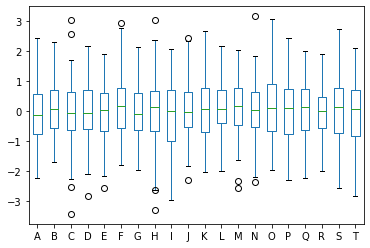

In [57]:
plot_boxplot(df.drop("y", axis=1))

# Histogram

<AxesSubplot:ylabel='Count'>

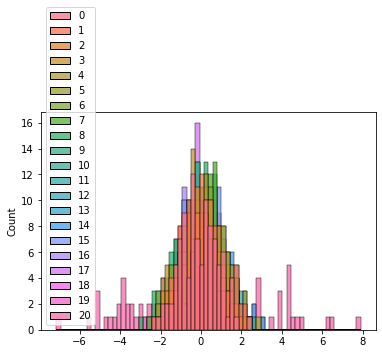

In [87]:
# Did not run... image on cache

#sns.histplot(data=df)
sns.histplot(data=df.drop("y", axis=1))